# ODE Review: Projectile Motion

Let's try solving for projectile motion with drag (air resistance).

We want to solve:

\begin{align*}
\dot{\bf r} &= {\bf v} \\
\dot{\bf v} &= \frac{1}{m} {\bf F}_a({\bf v}) - g \hat{\bf y}
\end{align*}

where $m$ is the mass of the projectile and

$${\bf F}_a({\bf v}) = - \frac{1}{2}C \rho_\mathrm{air} A |v| {\bf v}$$

is the [Newton drag term](https://en.wikipedia.org/wiki/Projectile_motion#Trajectory_of_a_projectile_with_Newton_drag) that
is applicable for large Reynolds numbers (turbulent), and $\rho_\mathrm{air}$ is the density of air, $C$ is the drag coefficient, $A$ is the cross-section
area of the projectile.

```{note}
Since the force here depends on velocity, we can't use the velocity-Verlet method.
```

We'll consider a baseball.  Then we can take:

* $C = 0.3$
* $A = \pi (d/2)^2$ with the diameter of a baseball, $d = 7.4~\mathrm{cm}$
* $m = 145~\mathrm{g}$
* $\rho_\mathrm{air} = 1.2\times 10^{-3}~\mathrm{g/cm^3}$

We also take gravity as constant, $g = 981~\mathrm{cm/s^2}$.

We'll imagine throwing the baseball from some height $y_0$ above the ground ($y = 0$) at an angle $\theta$ from the horizontal with velocity
magnitude $V$.

This means our initial conditions are:

\begin{align*}
x_0 &= 0 \\
y_0 &= y_0 \\
u_0 &= V \cos(\theta) \\
v_0 &= V \sin(\theta)
\end{align*}

and we want to integrate until the ball hits the ground, $y(t_\mathrm{max}) = 0$.

Let's implement this using 4th-order Runge-Kutta.

In [1]:
import numpy as np

In [2]:
C = 0.3
d = 7.4
m = 145
A = np.pi * (d/2)**2
rho_air = 1.2e-3
g = 981

In [3]:
def rhs(xvec, do_drag=True):
    x, y, u, v = xvec

    dxdt = u
    dydt = v

    if do_drag:
        vmag = np.sqrt(u*u + v*v)
        F_drag = -0.5 * C * rho_air * A * vmag
    else:
        F_drag = 0.0
        
    dudt = F_drag / m * u 
    dvdt = F_drag / m * v - g

    return np.array([dxdt, dydt, dudt, dvdt])

Now our integration routine.

Usually I would have defined a simple class to store the state at each
instance of time, which would make this code a bit more compact.  But
in class we decided to explicitly write everything out.

In [4]:
def integrate(dt, *, y0=100, vmag=5.e3, theta=45, do_drag=True):
    xs = [0]
    ys = [y0]
    us = [vmag * np.cos(np.radians(theta))]
    vs = [vmag * np.sin(np.radians(theta))]

    ts = [0]

    while ys[-1] > 0.0:

        # start with the previous state
        t = ts[-1]
        x = xs[-1]
        y = ys[-1]
        u = us[-1]
        v = vs[-1]

        k1 = rhs([x, y, u, v], do_drag=do_drag)

        k2 = rhs([x + 0.5*dt * k1[0],
                  y + 0.5*dt * k1[1],
                  u + 0.5*dt + k1[2],
                  v + 0.5*dt + k1[3]], do_drag=do_drag)

        k3 = rhs([x + 0.5*dt * k2[0],
                  y + 0.5*dt * k2[1],
                  u + 0.5*dt + k2[2],
                  v + 0.5*dt + k2[3]], do_drag=do_drag)

        k4 = rhs([x + dt * k3[0],
                  y + dt * k3[1],
                  u + dt + k3[2],
                  v + dt + k3[3]], do_drag=do_drag)
        
        x += dt/6 * (k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
        y += dt/6 * (k1[1] + 2*k2[1] + 2*k3[1] + k4[1])
        u += dt/6 * (k1[2] + 2*k2[2] + 2*k3[2] + k4[2])
        v += dt/6 * (k1[3] + 2*k2[3] + 2*k3[3] + k4[3])        

        xs.append(x)
        ys.append(y)
        us.append(u)
        vs.append(v)
        ts.append(t + dt)

    return ts, xs, ys, us, vs    

## Comparing drag vs. no drag

In [5]:
y0 = 100
vmag = 2000
theta = 45

In [6]:
t, x, y, u, v = integrate(0.02, y0=y0,
                          vmag=vmag, theta=theta)

In [7]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'y')

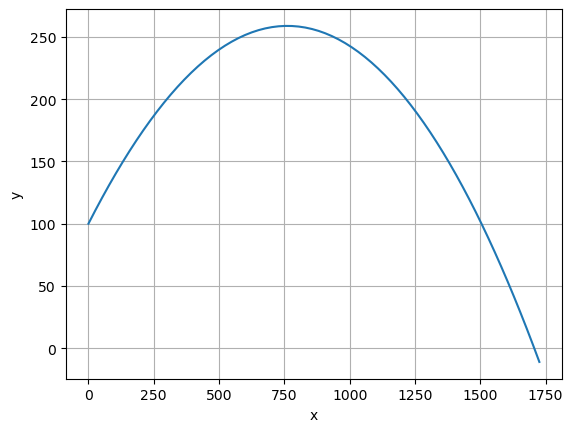

In [8]:
fig, ax = plt.subplots()
ax.plot(x, y, label="drag")
ax.grid()
ax.set_xlabel("x")
ax.set_ylabel("y")

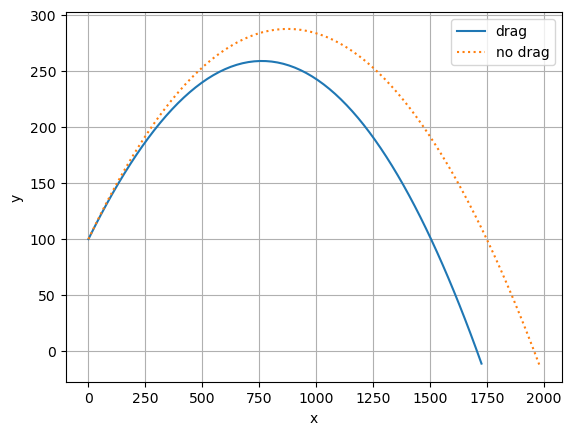

In [9]:
tn, xn, yn, un, vn = integrate(0.02, y0=y0,
                          vmag=vmag, theta=theta, do_drag=0)
ax.plot(xn, yn, label="no drag", ls=":")
ax.legend()

fig

## Variation with angle

Let's vary the angle to see the effect drag has

Text(0, 0.5, 'y')

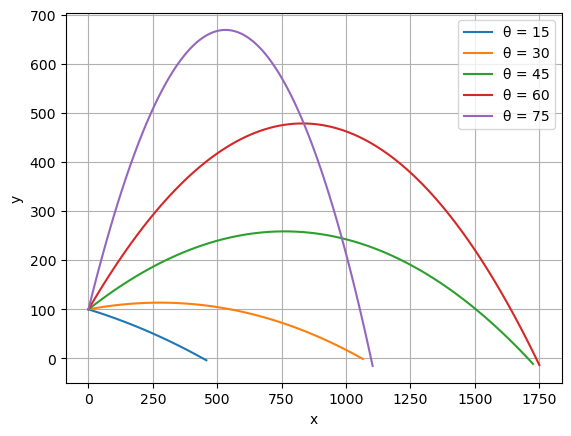

In [10]:
fig, ax = plt.subplots()

for theta in [15, 30, 45, 60, 75]:
    t, x, y, u, v = integrate(0.02, y0=y0,
                              vmag=vmag, theta=theta)
    ax.plot(x, y, label=f"θ = {theta}")

ax.legend()
ax.grid()
ax.set_xlabel("x")
ax.set_ylabel("y")